Implementation of a Naive Bayes classifier from scratch!!!

Here we define the imports, types, and global variables (stop words)

In [2]:
from __future__ import annotations
import csv
import email
import math
import matplotlib.pyplot as plt # type: ignore
import os
import random
import re
import types
from typing import List, Tuple, TypedDict


valid_token_pattern = r'(?<=\s)[a-zA-Z]+(?=\s|,|\.|\n)'
stop_tokens_pattern = r'(?<=\b)(xhtml|html|href|src|i|me|my|myself|we|our|ours|ourselves|you|your|yours|yourself|yourselves|he|him|his|himself|she|her|hers|herself|it|its|itself|they|them|their|theirs|themselves|what|which|who|whom|this|that|these|those|am|is|are|was|were|be|been|being|have|has|had|having|do|does|did|doing|a|an|the|and|but|if|or|because|as|until|while|of|at|by|for|with|about|against|between|into|through|during|before|after|above|below|to|from|up|down|in|out|on|off|over|under|again|further|then|once|here|there|when|where|why|how|all|any|both|each|few|more|most|other|some|such|no|nor|not|only|own|same|so|than|too|very|s|t|can|will|just|don|should|now)(?=\b)'


class ClassConditionalProbability(TypedDict):
    ham: dict[str, float]
    spam: dict[str, float]


class DocumentDict(TypedDict):
    parsed_dir: str
    classification: str
    tokens: List[str]


Preprocessor is just here to check the script but is not needed to run when trying to replicate the experiment since I should also be sending the csvs

In [3]:
class Preprocessor:

    def partition_files(self, seed: int = 23) -> Tuple[List[Tuple[str, str]]]:
        cwd = os.getcwd()
        ham_labels_and_dirs = []
        spam_labels_and_dirs = []
        with open(f'{cwd}/labels', 'r') as file:
            for line in file:
                label, directory = line.replace('\n', '').split(' ')
                parsed_dir = directory.replace('../', '')
                list_to_use = (
                    ham_labels_and_dirs
                    if label == 'ham'
                    else spam_labels_and_dirs
                )
                list_to_use.append((label, parsed_dir))

        random.seed(seed)
        random.shuffle(ham_labels_and_dirs)

        random.seed(seed)
        random.shuffle(spam_labels_and_dirs)

        training_ratio = 0.7

        ham_boundary = int(len(ham_labels_and_dirs) * training_ratio)
        spam_boundary = int(len(spam_labels_and_dirs) * training_ratio)

        ham_train_dirs = ham_labels_and_dirs[:ham_boundary]
        ham_test_dirs = ham_labels_and_dirs[ham_boundary:]

        spam_train_dirs = spam_labels_and_dirs[:spam_boundary]
        spam_test_dirs = spam_labels_and_dirs[spam_boundary:]

        train_dirs = ham_train_dirs + spam_train_dirs
        test_dirs = ham_test_dirs + spam_test_dirs

        random.seed(seed)
        random.shuffle(train_dirs)

        random.seed(seed)
        random.shuffle(test_dirs)

        return train_dirs, test_dirs
    
    def fetch_relevant_email_content(self, raw_email: str) -> str:
        msg = email.message_from_string(raw_email)
        content = f' {msg['subject']}'
        if msg.is_multipart():
            for part in msg.walk():
                if 'text' in part.get_content_type():
                    content += (
                        part.get_payload(decode=True)
                        .decode('utf-8', errors='ignore')
                    )
            return content
        else:
            payload = (msg.get_payload(decode=True)
                .decode('utf-8', errors='ignore'))
            return f" {msg['subject']} {payload}"
        
    def parse_email_to_usable_data(self, dir: str) -> List[str]:
        with open(dir, 'r', encoding='utf-8', errors='ignore') as file:
            content = file.read()
            cleaned_content = re.sub(r'[�]+', ' ', content)
            parsed_email = self.fetch_relevant_email_content(
                cleaned_content
            )
            extra_cleaned_content = re.sub(
                stop_tokens_pattern, 
                ' ', 
                parsed_email, 
                flags=re.IGNORECASE
            )
            
            tokens = re.findall(
                valid_token_pattern,
                extra_cleaned_content,
                flags=re.IGNORECASE
            )
            unique_tokens = list(
                set([token.lower() for token in tokens if len(token) > 2])
            )

        return unique_tokens
    
    def write_documents_to_csv(
        self,
        filename: str, 
        doc_set: List[Tuple[str, str]]
    ) -> None:
        keys = ['parsed_dir', 'label', 'tokens']
        with open(f'{filename}.csv', 'w', newline='') as csvfile:
            fieldnames = keys
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            writer.writeheader()
            for label, dir in doc_set:
                parsed_dir = dir.replace('/', '_')
                unique_tokens = self.parse_email_to_usable_data(dir)
                dict_to_write: DocumentDict = {
                    'parsed_dir': parsed_dir,
                    'label': label,
                    'tokens': ','.join(unique_tokens)
                }
                writer.writerow(dict_to_write)


In [24]:
# p = Preprocessor()
# train_dirs, test_dirs = p.partition_files()
# p.write_documents_to_csv('train_set', train_dirs)
# p.write_documents_to_csv('test_set', test_dirs)

The Naive Bayes classifier implementation

In [4]:
class NaiveBayesClassifier:
    def __init__(self) -> None:
        self._smoothing_factor = 1.0
        self._threshold = 1
        self._vocabulary_map = {}
        self._vocabulary: List[str] = []
        self._vocabulary_scheme = None
        self._doc_count = {
            'spam': 0,
            'ham': 0
        }
        self._prior_probabilities = {
            'ham': 0,
            'spam': 0
        }
        self._total_docs = 0
        self._likelihoods = {
            'ham': {},
            'spam': {}
        }
        
    @property
    def vocabulary(self) -> List[str]:
        if not self._vocabulary:
            return list(self._vocabulary_map.keys())
        else:
            return self._vocabulary
        
    @vocabulary.setter
    def vocabulary(self, vocabulary: List[str]) -> None:
        self._vocabulary = vocabulary

    @property
    def threshold(self) -> float:
        return self._threshold
    
    @threshold.setter
    def threshold(self, threshold: float) -> None:
        self._threshold = threshold
    
    @property
    def smoothing_factor(self) -> float:
        return self._smoothing_factor
    
    @smoothing_factor.setter
    def smoothing_factor(self, sf: float) -> None:
        self._smoothing_factor = sf

    @property
    def total_docs(self) -> int:
        if self._total_docs == 0:
            self._total_docs = self._doc_count['ham'] + self._doc_count['spam']
        return self._total_docs

    def train_model(self) -> None:
        # Only initialize the vocabulary map if it's empty
        if not len(self._vocabulary_map.keys()):
            with open('train_set.csv', 'r', newline='') as file:
                reader = csv.DictReader(file)
                for row in reader:
                    label = row['label']
                    tokens = row['tokens'].split(',')
                    self._doc_count[label] += 1

                    for token in tokens:
                        if not token:
                            continue
                        self._vocabulary_map.setdefault(token, {
                            'ham': 0,
                            'spam': 0
                        })
                        self._vocabulary_map[token][label] += 1


        self._prior_probabilities['ham'] = (
            self._doc_count['ham'] / self.total_docs)
        self._prior_probabilities['spam'] = (
            self._doc_count['spam'] / self.total_docs)
        
        vocabulary = []
        for token in self.vocabulary:
            total = (
                self._vocabulary_map[token]['ham'] 
                + self._vocabulary_map[token]['spam']
            )
            if total > 3:
                vocabulary.append(token)
        
            self._likelihoods['ham'][token] = self._compute_likelihood(
                token,
                'ham'
            )
            self._likelihoods['spam'][token] = self._compute_likelihood(
                token,
                'spam'
            )
        self.vocabulary = vocabulary

    def _compute_likelihood(self, token: str, label: str) -> float:
        token_count = self._vocabulary_map.get(token, {
            'ham': 0,
            'spam': 0
        })
        num = token_count[label] + self.smoothing_factor
        den = (
            self._doc_count[label]
            + (len(self.vocabulary) * self.smoothing_factor) 
        )
        return num / den
    
    def _predict_document_class(self, test_data: DocumentDict) -> None:
        spam_product = math.log(self._prior_probabilities['spam'])
        ham_product = math.log(self._prior_probabilities['ham'])
        tokens = test_data['tokens'].split(',')

        for token in self.vocabulary:
            p_token_is_ham = self._likelihoods['ham'][token]
            p_token_is_spam = self._likelihoods['spam'][token]

            if token not in tokens:
                p_token_is_ham = 1 - p_token_is_ham
                p_token_is_spam = 1 - p_token_is_spam

            spam_product += math.log(p_token_is_spam)
            ham_product += math.log(p_token_is_ham)

        spam_product = math.exp(spam_product)
        ham_product = math.exp(ham_product)

        if ham_product + spam_product == 0:
            return 'spam'

        p_ham_document = ham_product / (spam_product + ham_product)
        p_spam_document = spam_product / (spam_product + ham_product)
        is_spam = p_spam_document > self.threshold * p_ham_document
        return 'spam' if is_spam else 'ham'
    
    def predict(self, test_set_filename: str) -> List[Tuple[str, str]]:
        """
        Output is List[(label, prediction)]
        """
        label_and_predictions = []
        with open(f'{test_set_filename}.csv', 'r', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                label = row['label']
                prediction = self._predict_document_class(row)
                label_and_predictions.append((label, prediction))
        return label_and_predictions

    def compute_precision_and_recall(
        self,
        labels_and_predictions: List[Tuple[str, str]]
    ):
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        for label, prediction in labels_and_predictions:
            if label == 'spam' and prediction == 'spam':
                tp += 1
            elif label == 'ham' and prediction == 'ham':
                tn += 1
            elif label == 'ham' and prediction == 'spam':
                fp += 1
            elif label == 'spam' and prediction == 'ham':
                fn += 1
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

        return { 
            'precision': precision, 
            'recall': recall,
            'tp': tp,
            'fp': fp,
            'tn': tn,
            'fn': fn
        }

Instantiate and print some statistics

In [5]:
nbc = NaiveBayesClassifier()
nbc.train_model()    

print (
    f'\n\nHam docs: {nbc._doc_count['ham']}; '
    f'Spam docs: {nbc._doc_count['spam']}; '
    f'Total docs: {nbc.total_docs}'
)
print(
    f'\nP(w = ham) = {nbc._prior_probabilities["ham"]}; '
    f'P(w = spam) = {nbc._prior_probabilities["spam"]}'
)




Ham docs: 9037; Spam docs: 17438; Total docs: 26475

P(w = ham) = 0.3413408876298395; P(w = spam) = 0.6586591123701605


Run the base case that was asked in the problem

In [61]:
nbc.smoothing_factor = 1
nbc.train_model()
label_and_predictions = nbc.predict('test_set')
nbc.compute_precision_and_recall(label_and_predictions)

{'precision': 0.9313574544521427,
 'recall': 0.9712336098474712,
 'tp': 7259,
 'fp': 535,
 'tn': 3338,
 'fn': 215}

Now try different smoothing factors

In [62]:
smoothing_factors = [4, 2, 1, 0.5, 0.1, 0.005]
sf_map = {}
for sf in smoothing_factors:
    nbc.smoothing_factor = sf
    nbc.train_model()
    predictions = nbc.predict('test_set')
    values_map = nbc.compute_precision_and_recall(predictions)
    sf_map[sf] = values_map

Plots for smoothing factor variation

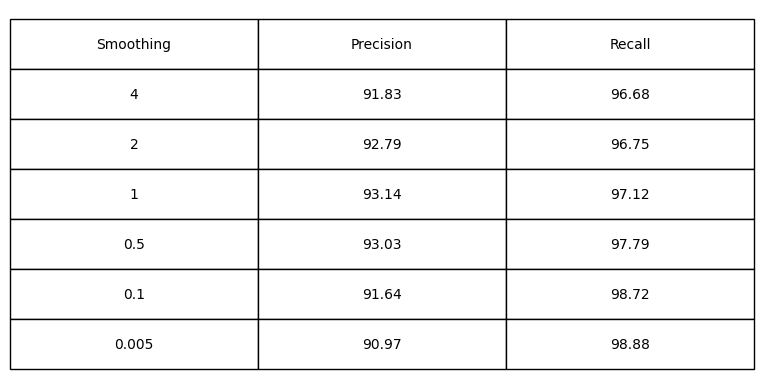

In [63]:
sf_fig, sf_ax = plt.subplots()

sf_ax.axis('off')
sf_ax.axis('tight')

sf_headers = ['Smoothing', 'Precision', 'Recall']
sf_table_data = []
s_factors = []
fps = []
tps = []
precisions = []
recalls = []
for sf, metrics in sf_map.items():
    precision = round(float(metrics['precision']) * 100, 2)
    recall = round(float(metrics['recall']) * 100, 2)
    tp = metrics['tp']
    fp = metrics['fp']
    row = [sf, precision, recall]
    precisions.append(precision)
    recalls.append(recall)
    fps.append(fp)
    tps.append(tp)
    s_factors.append(sf)
    sf_table_data.append(row)

sf_table = sf_ax.table(
    cellText=sf_table_data, 
    colLabels=sf_headers, 
    cellLoc='center', loc='center'
)
sf_table.scale(1.5, 3)

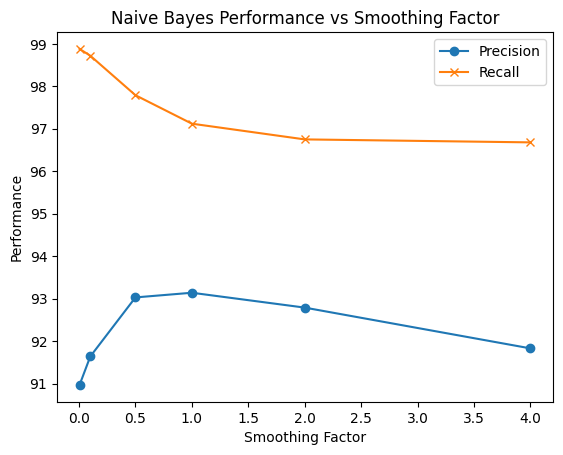

In [64]:
plt.plot(smoothing_factors, precisions, label='Precision', marker='o')
plt.plot(smoothing_factors, recalls, label='Recall', marker='x')
# plt.plot(smoothing_factors, f2_scores, label='F1 Score', marker='o')

# Add labels and title
plt.xlabel('Smoothing Factor')
plt.ylabel('Performance')
plt.title('Naive Bayes Performance vs Smoothing Factor')

# Show legend
plt.legend()

# Show the plot
plt.show()

Start of MI-ranking

In [65]:
def mutual_information(
    self: NaiveBayesClassifier
) -> List[Tuple[str, float]]:
    mi_list = []
    for token in self._vocabulary_map.keys():
        mutual_information = 0
        for i in (1, 0):
            p_ham_conditional = self._likelihoods['ham'][token]
            p_spam_conditional = self._likelihoods['spam'][token]

            if i == 0:
                p_ham_conditional = 1 - p_ham_conditional
                p_spam_conditional = 1 - p_spam_conditional

            p_spam_prior = self._prior_probabilities['spam']
            p_ham_prior = self._prior_probabilities['ham']

            p_ham_joint = p_ham_conditional * p_ham_prior
            p_spam_joint = p_spam_conditional * p_spam_prior
            
            p_marginal = p_ham_joint + p_spam_joint

            # For current i and spam
            mi_partial_spam = p_spam_joint * math.log(
                p_spam_joint / (p_marginal * p_spam_prior)
            )
            mi_partial_ham = p_ham_joint * math.log(
                p_ham_joint / (p_marginal * p_ham_prior)
            )
            mi_partial = mi_partial_ham + mi_partial_spam
            mutual_information += mi_partial
        
        mi_list.append((token, mutual_information))

    
    sorted_mi_list = sorted(mi_list, key=lambda x: x[1], reverse=True)
    return sorted_mi_list
    

nbc.mutual_information = types.MethodType(mutual_information, nbc)

MI-ranking for base case of 200 top ranking tokens

In [66]:
nbc.smoothing_factor = 1
sorted_mi_list = nbc.mutual_information()
new_vocabulary_list = [
    item[0] 
    for item in sorted_mi_list[:200] 
    if item[0]
]
nbc.vocabulary = new_vocabulary_list
predictions = nbc.predict('test_set')
metrics = nbc.compute_precision_and_recall(predictions)
metrics


{'precision': 0.9196153846153846,
 'recall': 0.9597270537864597,
 'tp': 7173,
 'fp': 627,
 'tn': 3246,
 'fn': 301}

Checking what the optimal number of words should we select to maximize precision and recall

In [67]:
# Train again with the most optimal smoothing factor
nbc.smoothing_factor = 1
mi_token_map = {}
mi_tokens = 200
while mi_tokens < 3000:
    new_vocabulary_list = [
        item[0] 
        for item in sorted_mi_list[:mi_tokens] 
        if item[0]
    ]
    nbc.vocabulary = new_vocabulary_list
    predictions = nbc.predict('test_set')
    metrics = nbc.compute_precision_and_recall(predictions)
    mi_token_map[mi_tokens] = metrics
    mi_tokens += 200


Plots for MI

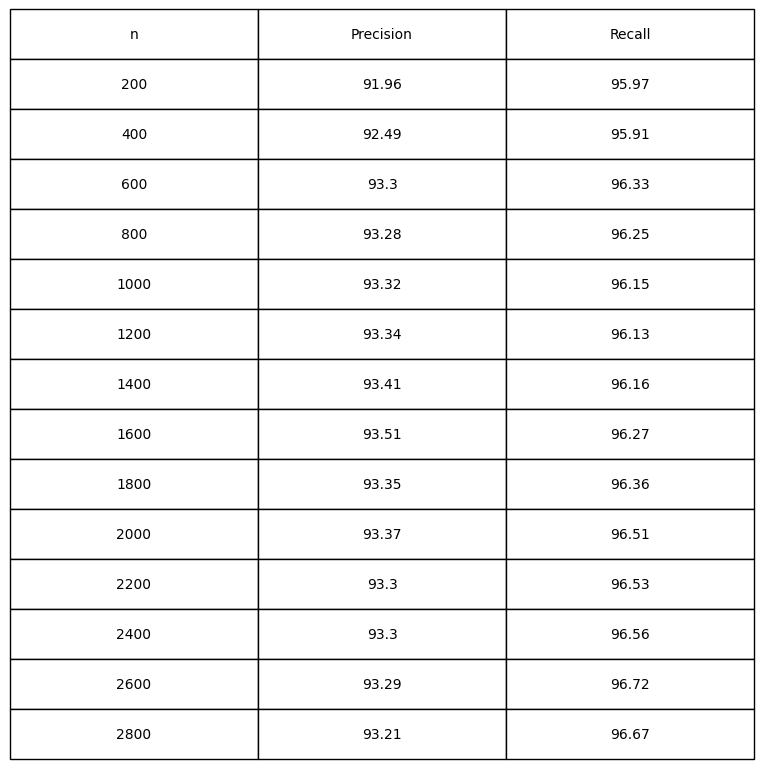

In [105]:
mi_fig, mi_ax = plt.subplots()

mi_ax.axis('off')
mi_ax.axis('tight')

mi_headers = ['n', 'Precision', 'Recall']
mi_table_data = []
mi_factors = []
fps = []
tps = []
mi_precisions = []
mi_recalls = []
for n, metrics in mi_token_map.items():
    precision = round(float(metrics['precision']) * 100, 2)
    recall = round(float(metrics['recall']) * 100, 2)
    tp = metrics['tp']
    fp = metrics['fp']
    row = [n, precision, recall]
    mi_precisions.append(precision)
    mi_recalls.append(recall)
    fps.append(fp)
    tps.append(tp)
    mi_factors.append(n)
    mi_table_data.append(row)

mi_table = mi_ax.table(
    cellText=mi_table_data, 
    colLabels=mi_headers, 
    cellLoc='center', loc='center'
)
mi_table.scale(1.5, 3)

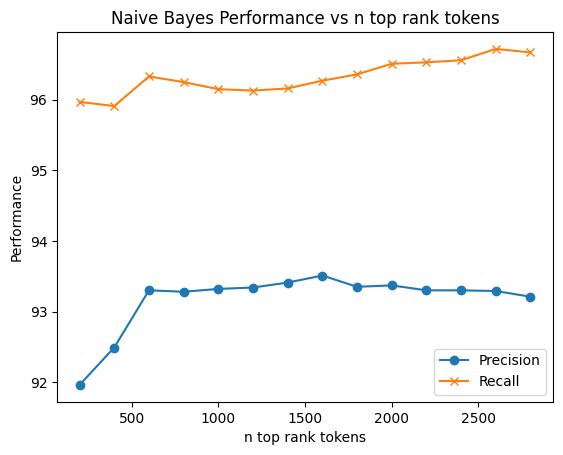

In [80]:
plt.plot(mi_factors, mi_precisions, label='Precision', marker='o')
plt.plot(mi_factors, mi_recalls, label='Recall', marker='x')

# Add labels and title
plt.xlabel('n top rank tokens')
plt.ylabel('Performance')
plt.title('Naive Bayes Performance vs n top rank tokens')

# Show legend
plt.legend()

# Show the plot
plt.show()

Varying the threshold

In [69]:
#Use 1600
sorted_mi_list = nbc.mutual_information()
nbc.vocabulary = [
    item[0] 
    for item in sorted_mi_list[:1600] 
    if item[0]
]
threshold_map = {}
for i in range(0, 21):
    new_threshold = 10 ** i
    nbc.threshold = new_threshold
    predictions = nbc.predict('test_set')
    metrics = nbc.compute_precision_and_recall(predictions)
    threshold_map[new_threshold] = metrics

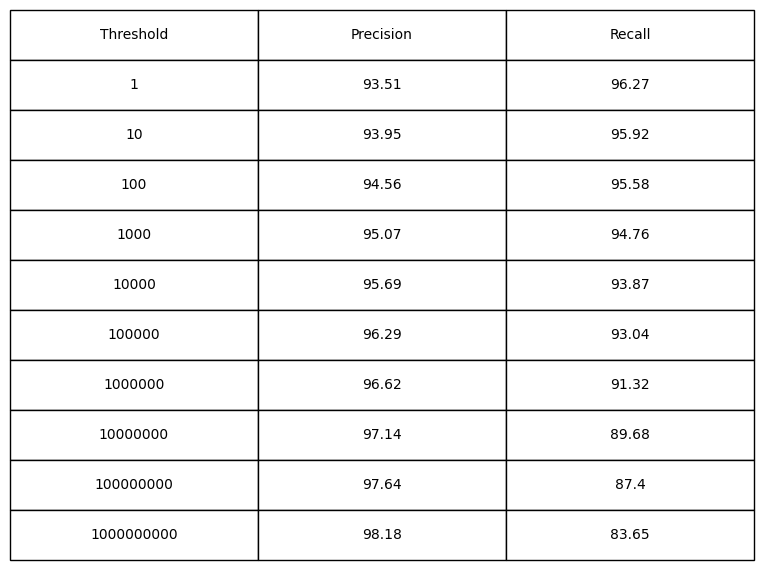

In [110]:
th_fig, th_ax = plt.subplots()

th_ax.axis('off')
th_ax.axis('tight')

th_headers = ['Threshold', 'Precision', 'Recall']
th_table_data = []
th_factors = []
fps = []
tps = []
th_precisions = []
th_recalls = []
for threshold, metrics in threshold_map.items():
    precision = round(float(metrics['precision']) * 100, 2)
    recall = round(float(metrics['recall']) * 100, 2)
    tp = metrics['tp']
    fp = metrics['fp']
    row = [threshold, precision, recall]
    th_precisions.append(precision)
    th_recalls.append(recall)
    fps.append(fp)
    tps.append(tp)
    th_factors.append(threshold)
    th_table_data.append(row)

th_table = th_ax.table(
    cellText=th_table_data[0:10], 
    colLabels=th_headers, 
    cellLoc='center', loc='center'
)
th_table.scale(1.5, 3)

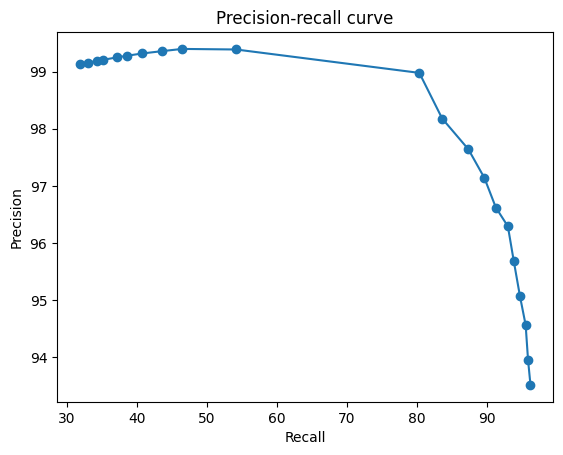

In [94]:

th_fig, th_ax = plt.subplots()

th_table_data = []
th_factors = []
fps = []
tps = []
th_precisions = []
th_recalls = []
th_precisions = []
th_recalls = []
for threshold, metrics in threshold_map.items():
    precision = round(float(metrics['precision']) * 100, 2)
    recall = round(float(metrics['recall']) * 100, 2)
    tp = metrics['tp']
    fp = metrics['fp']
    row = [precision, recall]
    th_precisions.append(precision)
    th_recalls.append(recall)
    fps.append(fp)
    tps.append(tp)
    th_factors.append(threshold)
    th_table_data.append(row)

plt.plot(th_recalls, th_precisions, label='Precision', marker='o')

# Add labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve')

# Show the plot
plt.show()

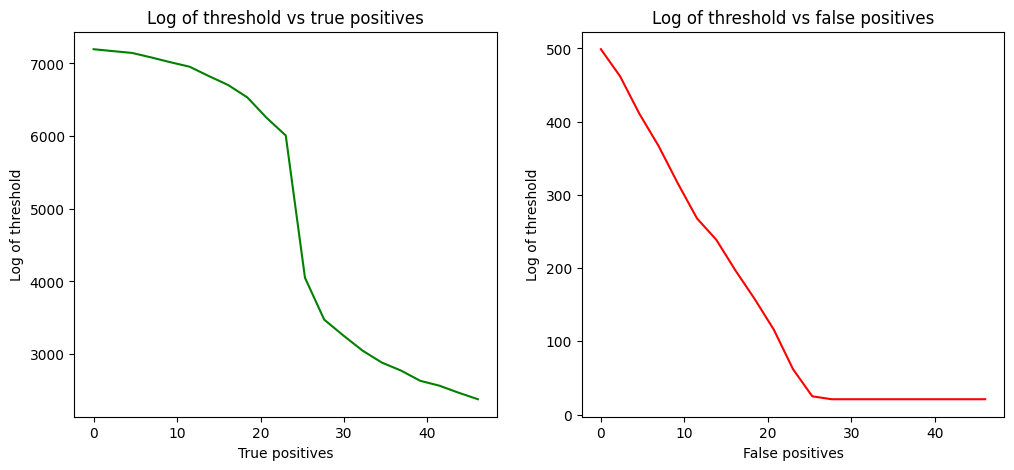

In [103]:
log_th_factors = [math.log(th) for th in th_factors]
p_fig, (p_ax1, p_ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first axis
p_ax1.plot(log_th_factors, tps, color='green')
p_ax1.set_title('Log of threshold vs true positives')
p_ax1.set_xlabel('True positives')
p_ax1.set_ylabel('Log of threshold')

# Plot the second axis
p_ax2.plot(log_th_factors, fps, color='red')
p_ax2.set_title('Log of threshold vs false positives')
p_ax2.set_xlabel('False positives')
p_ax2.set_ylabel('Log of threshold')


plt.show()